In [1]:
# الخلية 1: استيراد المكتبات وتحميل وتجهيز الميزات (مع تضمينات الجمل)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# from scipy.sparse import hstack, csr_matrix # لم نعد بحاجة إليها إذا كانت جميع الميزات كثيفة

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)      
pd.set_option('display.width', 1000)       
pd.set_option('display.float_format', '{:.2f}'.format)

print("--- الخلية 1: بدء استيراد المكتبات وتحميل البيانات (مع تضمينات الجمل) ---")
print("المكتبات الأساسية تم استيرادها.")

project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
processed_data_path = os.path.join(project_root, 'data', 'processed', 'processed_problems_data.csv')
    
date_columns_to_parse = ['date_identified', 'date_closed', 'date_chosen', 
                         'start_date_planned', 'end_date_planned', 
                         'start_date_actual', 'end_date_actual']
try:
    df_processed = pd.read_csv(processed_data_path, parse_dates=date_columns_to_parse)
    print(f"تم تحميل 'processed_problems_data.csv' بنجاح. الأبعاد: {df_processed.shape}")
except FileNotFoundError:
    print(f"خطأ: لم يتم العثور على ملف '{processed_data_path}'.")
    df_processed = pd.DataFrame()
except Exception as e:
    print(f"حدث خطأ آخر أثناء تحميل البيانات: {e}")
    df_processed = pd.DataFrame()

if not df_processed.empty:
    print("\n--- بدء تجهيز الميزات للنماذج (باستخدام تضمينات الجمل) ---")
    df_for_features = df_processed.copy()
    text_feature_col = 'processed_text'
    numerical_features = ['estimated_cost_numeric', 'overall_budget_numeric', 
                          'estimated_time_days', 'processed_text_length'] 
    numerical_features = [col for col in numerical_features if col in df_for_features.columns and pd.api.types.is_numeric_dtype(df_for_features[col])]
    categorical_features_to_encode = ['domain', 'complexity_level', 'status', 'problem_source', 'sentiment_label']
    categorical_features_to_encode = [col for col in categorical_features_to_encode if col in df_for_features.columns]
    print(f"الميزة النصية (للتضمين): {text_feature_col}")
    print(f"الميزات الرقمية: {numerical_features}")
    print(f"الميزات الفئوية: {categorical_features_to_encode}")

    for col in numerical_features:
        if df_for_features[col].isnull().any():
            median_val = df_for_features[col].median()
            df_for_features[col] = df_for_features[col].fillna(median_val)
            # print(f"تم ملء NaN في '{col}' (رقمي) بالوسيط: {median_val}") # يمكن إلغاء التعليق للتحقق
    for col in categorical_features_to_encode:
        if df_for_features[col].isnull().any():
            if not pd.api.types.is_string_dtype(df_for_features[col]) and pd.api.types.is_object_dtype(df_for_features[col]):
                df_for_features[col] = df_for_features[col].astype(str)
            df_for_features[col] = df_for_features[col].fillna('Unknown')
            # print(f"تم ملء NaN في '{col}' (فئوي) بـ 'Unknown'")
    if text_feature_col in df_for_features.columns and df_for_features[text_feature_col].isnull().any():
        df_for_features[text_feature_col] = df_for_features[text_feature_col].fillna('')
        # print(f"تم ملء NaN في '{text_feature_col}' (نصي) بنص فارغ.")

    print(f"\nإنشاء تضمينات الجمل للعمود: {text_feature_col}...")
    embedding_model_name_for_kmeans = 'paraphrase-multilingual-MiniLM-L12-v2'
    try:
        sentence_model_kmeans = SentenceTransformer(embedding_model_name_for_kmeans)
        texts_to_embed = df_for_features[text_feature_col].astype(str).tolist()
        print(f"تحويل {len(texts_to_embed)} نص إلى تضمينات (قد يستغرق بعض الوقت)...")
        text_embeddings = sentence_model_kmeans.encode(texts_to_embed, show_progress_bar=True)
        df_text_embeddings = pd.DataFrame(text_embeddings, index=df_for_features.index)
        df_text_embeddings.columns = [f'embed_{i}' for i in range(df_text_embeddings.shape[1])]
        print(f"أبعاد مصفوفة تضمينات النصوص: {df_text_embeddings.shape}")
    except Exception as e:
        print(f"خطأ أثناء إنشاء تضمينات الجمل: {e}")
        df_text_embeddings = pd.DataFrame(index=df_for_features.index)

    numeric_pipeline = Pipeline([('scaler', StandardScaler())])
    categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))])
    column_transformer_num_cat = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numerical_features),
            ('cat', categorical_pipeline, categorical_features_to_encode)
        ], remainder='drop' 
    )
    print("\nتطبيق ColumnTransformer على الميزات الرقمية والفئوية...")
    processed_num_cat_features_array = column_transformer_num_cat.fit_transform(df_for_features)
    try: 
        ohe_feature_names = column_transformer_num_cat.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features_to_encode)
        all_num_cat_feature_names = numerical_features + list(ohe_feature_names)
        df_processed_num_cat = pd.DataFrame(processed_num_cat_features_array, columns=all_num_cat_feature_names, index=df_for_features.index)
    except Exception as e: 
        print(f"تحذير: لم يتمكن من الحصول على أسماء الميزات من ColumnTransformer: {e}.")
        df_processed_num_cat = pd.DataFrame(processed_num_cat_features_array, index=df_for_features.index)
    print(f"أبعاد الميزات الرقمية والفئوية المجهزة: {df_processed_num_cat.shape}")

    print("\nدمج جميع الميزات...")
    if not df_text_embeddings.index.equals(df_processed_num_cat.index):
        print("تحذير! عدم تطابق في الفهرس بين الميزات الرقمية/الفئوية وتضمينات النصوص.")
    X_final_df = pd.concat([df_processed_num_cat, df_text_embeddings], axis=1)
    print(f"أبعاد مصفوفة الميزات النهائية (X_final_df) بعد دمج التضمينات: {X_final_df.shape}")
    print("عينة من مصفوفة الميزات النهائية (أول 5 صفوف، أول 10 أعمدة):")
    display(X_final_df.iloc[:5, :10])
    print("\nالتحقق من القيم المفقودة في X_final_df:")
    print(f"مجموع القيم المفقودة: {X_final_df.isnull().sum().sum()}")

    models_dir = os.path.join(project_root, 'data', 'models')
    os.makedirs(models_dir, exist_ok=True)
    # *** حفظ المحول الصحيح بالاسم الصحيح ***
    joblib.dump(column_transformer_num_cat, os.path.join(models_dir, 'ct_num_cat_embeddings_preprocessor.pkl'))
    print("\nتم حفظ ColumnTransformer (للميزات الرقمية والفئوية) في 'data/models/ct_num_cat_embeddings_preprocessor.pkl'.")
    print("--- الخلية 1: اكتمل تحميل وتجهيز الميزات (مع تضمينات الجمل) ---")
else:
    print("لم يتم تحميل df_processed، لا يمكن المتابعة.")
    X_final_df = None 

C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- الخلية 1: بدء استيراد المكتبات وتحميل البيانات (مع تضمينات الجمل) ---
المكتبات الأساسية تم استيرادها.
تم تحميل 'processed_problems_data.csv' بنجاح. الأبعاد: (8, 52)

--- بدء تجهيز الميزات للنماذج (باستخدام تضمينات الجمل) ---
الميزة النصية (للتضمين): processed_text
الميزات الرقمية: ['estimated_cost_numeric', 'overall_budget_numeric', 'estimated_time_days']
الميزات الفئوية: ['domain', 'complexity_level', 'status', 'problem_source', 'sentiment_label']

إنشاء تضمينات الجمل للعمود: processed_text...
تحويل 8 نص إلى تضمينات (قد يستغرق بعض الوقت)...


Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]

أبعاد مصفوفة تضمينات النصوص: (8, 384)

تطبيق ColumnTransformer على الميزات الرقمية والفئوية...
أبعاد الميزات الرقمية والفئوية المجهزة: (8, 15)

دمج جميع الميزات...
أبعاد مصفوفة الميزات النهائية (X_final_df) بعد دمج التضمينات: (8, 399)
عينة من مصفوفة الميزات النهائية (أول 5 صفوف، أول 10 أعمدة):


,estimated_cost_numeric,overall_budget_numeric,estimated_time_days,domain_تعليم عالي - تكنولوجيا,domain_تقني,domain_شخصي,domain_شخصي - صيانة سيارة,complexity_level_بسيط,complexity_level_متوسط,status_مغلقة
0,-0.38,-0.24,-0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2.65,2.54,2.65,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,-0.38,-0.24,-0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.38,-0.24,-0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.38,-0.24,-0.38,0.00,1.00,0.00,0.00,1.00,0.00,0.00



التحقق من القيم المفقودة في X_final_df:
مجموع القيم المفقودة: 0

تم حفظ ColumnTransformer (للميزات الرقمية والفئوية) في 'data/models/ct_num_cat_embeddings_preprocessor.pkl'.
--- الخلية 1: اكتمل تحميل وتجهيز الميزات (مع تضمينات الجمل) ---



--- الخلية 2: بدء تدريب نموذج K-Means ---
أبعاد مصفوفة الميزات X_final_df المستخدمة للتدريب: (8, 399)
نطاق قيم k التي سيتم تجربتها: [2, 3, 4, 5, 6, 7]
تم حساب K-Means لـ k=2, Inertia: 89.25
تم حساب K-Means لـ k=3, Inertia: 72.16
تم حساب K-Means لـ k=4, Inertia: 59.21
تم حساب K-Means لـ k=5, Inertia: 26.42
تم حساب K-Means لـ k=6, Inertia: 14.59
تم حساب K-Means لـ k=7, Inertia: 5.43


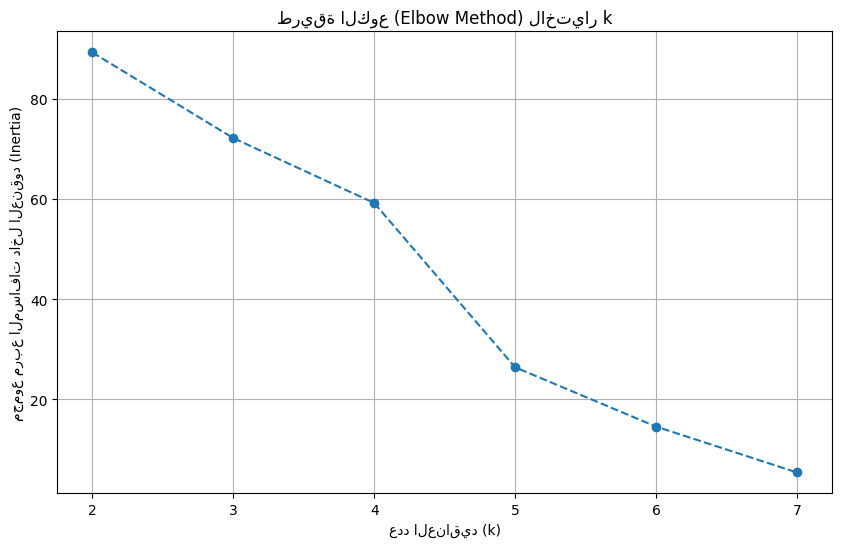

تم حساب Silhouette Score لـ k=2: 0.210
تم حساب Silhouette Score لـ k=3: 0.050
تم حساب Silhouette Score لـ k=4: -0.018
تم حساب Silhouette Score لـ k=5: 0.047
تم حساب Silhouette Score لـ k=6: 0.058
تم حساب Silhouette Score لـ k=7: 0.032


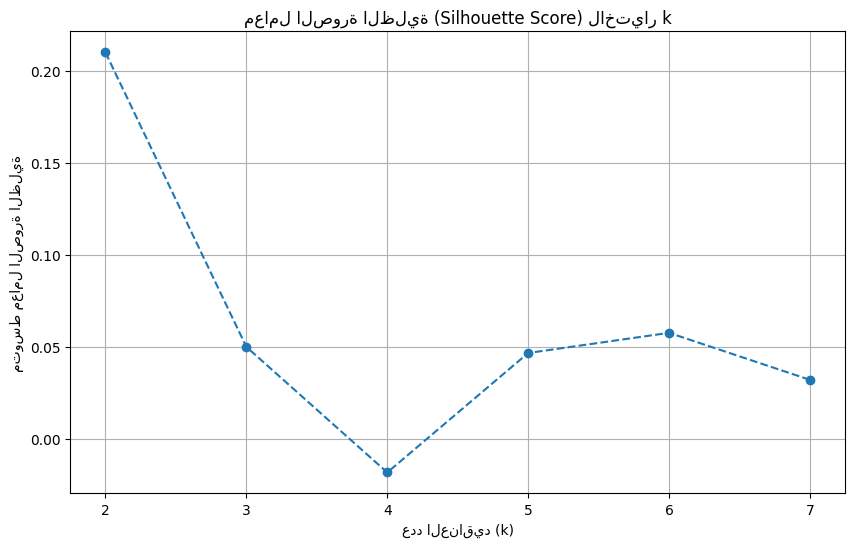

القيمة المقترحة لـ k بناءً على أعلى Silhouette Score: 2

سيتم تدريب نموذج K-Means النهائي بـ k = 2 عنقود(عناقيد).

توزيع المشاكل على العناقيد:
cluster_kmeans
0    7
1    1
Name: count, dtype: int64

عينة من المشاكل مع تسميات العناقيد:


,problem_id,title,cluster_kmeans
0,1,حب من جهة واحدة,0
1,3,انخفاض ملحوظ في تفاعل الطلاب مع منصة التعلم ال...,0
2,4,مفاتيح السيارة ضاعت مني,0
3,5,أختناق مروري,0
4,10,موبايل مكسور,0
5,11,ماوس كومبيوتري لا يشتغل,0
6,12,نقص هواء في الإطار الأمامي الأيسر للسيارة,1
7,13,جهاز الموبايل مسروق,0


تم حفظ DataFrame مع تسميات عناقيد K-Means في: C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\data\processed\problems_with_kmeans_clusters.csv
تم حفظ نموذج K-Means المدرب في: C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\data\models\kmeans_model.pkl
--- الخلية 2: اكتمل تدريب K-Means (إذا كان عدد العينات كافيًا) ---


In [2]:
# الخلية 2: تدريب نموذج K-Means واختيار عدد العناقيد (k)

if 'X_final_df' in locals() and X_final_df is not None and not X_final_df.empty:
    print(f"\n--- الخلية 2: بدء تدريب نموذج K-Means ---")
    print(f"أبعاد مصفوفة الميزات X_final_df المستخدمة للتدريب: {X_final_df.shape}")

    max_k = min(7, X_final_df.shape[0] - 1) 
    if max_k < 2:
        print("عدد العينات قليل جدًا (أقل من 2) لتطبيق K-Means بشكل فعال.")
        k_range = []
    else:
        k_range = range(2, max_k + 1) 

    print(f"نطاق قيم k التي سيتم تجربتها: {list(k_range)}")
    inertia_values = []
    if k_range: 
        for k_test in k_range:
            kmeans_test = KMeans(n_clusters=k_test, init='k-means++', n_init='auto', random_state=42)
            kmeans_test.fit(X_final_df)
            inertia_values.append(kmeans_test.inertia_)
            print(f"تم حساب K-Means لـ k={k_test}, Inertia: {kmeans_test.inertia_:.2f}")
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia_values, marker='o', linestyle='--')
        plt.title('طريقة الكوع (Elbow Method) لاختيار k')
        plt.xlabel('عدد العناقيد (k)'); plt.ylabel('مجموع مربع المسافات داخل العنقود (Inertia)')
        plt.xticks(list(k_range)); plt.grid(True); plt.show()
    else: print("لا يمكن تطبيق طريقة الكوع.")

    silhouette_scores = []
    optimal_k_silhouette = None # تهيئة
    if k_range: 
        for k_test in k_range:
            kmeans_test = KMeans(n_clusters=k_test, init='k-means++', n_init='auto', random_state=42)
            cluster_labels_test = kmeans_test.fit_predict(X_final_df)
            if len(set(cluster_labels_test)) > 1 and len(set(cluster_labels_test)) < X_final_df.shape[0]:
                score = silhouette_score(X_final_df, cluster_labels_test)
                silhouette_scores.append(score)
                print(f"تم حساب Silhouette Score لـ k={k_test}: {score:.3f}")
            else:
                silhouette_scores.append(-1) 
                print(f"لا يمكن حساب Silhouette Score بشكل صحيح لـ k={k_test}.")
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
        plt.title('معامل الصورة الظلية (Silhouette Score) لاختيار k')
        plt.xlabel('عدد العناقيد (k)'); plt.ylabel('متوسط معامل الصورة الظلية')
        plt.xticks(list(k_range)); plt.grid(True); plt.show()
        if any(s > -1 for s in silhouette_scores): 
            optimal_k_silhouette = k_range[np.argmax(silhouette_scores)] if silhouette_scores else None
            print(f"القيمة المقترحة لـ k بناءً على أعلى Silhouette Score: {optimal_k_silhouette}")
        else: print("لم يتم العثور على قيمة k مثلى بناءً على Silhouette Score.")
    else: print("لا يمكن تطبيق معامل الصورة الظلية.")
    
    chosen_k = None
    if optimal_k_silhouette and optimal_k_silhouette > 1: chosen_k = optimal_k_silhouette
    elif len(X_final_df) >= 3: 
        chosen_k = min(3, len(X_final_df) -1); 
        if chosen_k < 2 : chosen_k = 2
    elif len(X_final_df) == 2: chosen_k = 2
    else: print("عدد العينات غير كافٍ لتطبيق K-Means.")

    if chosen_k:
        print(f"\nسيتم تدريب نموذج K-Means النهائي بـ k = {chosen_k} عنقود(عناقيد).")
        kmeans_final = KMeans(n_clusters=chosen_k, init='k-means++', n_init='auto', random_state=42)
        cluster_labels_final = kmeans_final.fit_predict(X_final_df)
        
        # df_processed يجب أن يكون متاحًا من الخلية 1
        if 'df_processed' in locals() and not df_processed.empty:
            df_processed_with_clusters = df_processed.copy()
            df_processed_with_clusters['cluster_kmeans'] = cluster_labels_final
            print("\nتوزيع المشاكل على العناقيد:")
            print(df_processed_with_clusters['cluster_kmeans'].value_counts())
            print("\nعينة من المشاكل مع تسميات العناقيد:")
            display(df_processed_with_clusters[['problem_id', 'title', 'cluster_kmeans']].head(10))
            
            # حفظ DataFrame مع العناقيد
            kmeans_clusters_csv_path = os.path.join(project_root, 'data', 'processed', 'problems_with_kmeans_clusters.csv')
            df_processed_with_clusters.to_csv(kmeans_clusters_csv_path, index=False, encoding='utf-8-sig')
            print(f"تم حفظ DataFrame مع تسميات عناقيد K-Means في: {kmeans_clusters_csv_path}")
        else:
            print("تحذير: df_processed غير متاح، لن يتم حفظ DataFrame مع العناقيد.")

        # حفظ نموذج K-Means المدرب
        models_dir_kmeans = os.path.join(project_root, 'data', 'models') # تأكد أن models_dir معرف
        os.makedirs(models_dir_kmeans, exist_ok=True)
        kmeans_model_path = os.path.join(models_dir_kmeans, 'kmeans_model.pkl')
        joblib.dump(kmeans_final, kmeans_model_path)
        print(f"تم حفظ نموذج K-Means المدرب في: {kmeans_model_path}")

    print(f"--- الخلية 2: اكتمل تدريب K-Means (إذا كان عدد العينات كافيًا) ---")
else:
    print("مصفوفة الميزات X_final_df غير متاحة أو فارغة. لا يمكن تدريب نموذج K-Means.")

In [3]:
# الخلية 3: تحليل خصائص العناقيد الناتجة عن K-Means

if 'df_processed_with_clusters' in locals() and not df_processed_with_clusters.empty:
    print(f"\n--- الخلية 3: بدء تحليل خصائص عناقيد K-Means ---")

    # --- 1. عرض ملخص لكل عنقود ---
    # (عدد المشاكل، متوسط القيم الرقمية، القيم الفئوية الشائعة)
    
    # الأعمدة الرقمية الأصلية التي قد تكون مفيدة للتحليل (قبل التحجيم)
    # نستخدم df_processed الذي يحتوي على القيم الأصلية قبل التحجيم للمعنى الأوضح
    original_numerical_to_analyze = ['estimated_cost_numeric', 'overall_budget_numeric', 
                                     'estimated_time_days', 'processed_text_length', 'sentiment_score']
    # تأكد من وجود هذه الأعمدة في df_processed
    existing_original_numerical = [col for col in original_numerical_to_analyze if col in df_processed.columns]

    # الأعمدة الفئوية الأصلية
    original_categorical_to_analyze = ['domain', 'complexity_level', 'status', 'problem_source', 'sentiment_label']
    existing_original_categorical = [col for col in original_categorical_to_analyze if col in df_processed.columns]

    for cluster_id in sorted(df_processed_with_clusters['cluster_kmeans'].unique()):
        print(f"\n--- تحليل العنقود رقم: {cluster_id} ---")
        cluster_data = df_processed_with_clusters[df_processed_with_clusters['cluster_kmeans'] == cluster_id]
        
        print(f"عدد المشاكل في هذا العنقود: {len(cluster_data)}")
        
        print("\nعناوين المشاكل في هذا العنقود:")
        for title in cluster_data['title'].tolist():
            print(f"- {title}")
            
        if existing_original_numerical:
            print("\nمتوسط القيم للميزات الرقمية الأصلية:")
            display(cluster_data[existing_original_numerical].mean().to_frame().T) # .T لقلب الجدول لسهولة القراءة
            
        if existing_original_categorical:
            print("\nالقيم الأكثر شيوعًا للميزات الفئوية الأصلية:")
            for col in existing_original_categorical:
                # عرض القيم الفريدة وعددها إذا كانت قليلة، أو الأكثر شيوعًا فقط
                mode_info = cluster_data[col].mode()
                if not mode_info.empty:
                    # إذا كان هناك أكثر من قيمة شائعة (نفس العدد)، اعرضها كلها
                    common_values = ", ".join(mode_info.tolist())
                    print(f"- {col}: {common_values} (بنسبة { (cluster_data[col].value_counts(normalize=True).max() * 100):.1f}% للوضع الأكثر شيوعًا إذا كان وحيدًا)")
                else:
                    print(f"- {col}: لا توجد قيمة شائعة (قد تكون كلها فريدة أو مفقودة)")

    # --- 2. (اختياري) تحليل الكلمات الرئيسية لكل عنقود ---
    # هذا يتطلب الوصول إلى مصفوفة TF-IDF والمفردات من الخلية 1
    # إذا كنت تريد القيام بذلك، يمكننا إضافة الكود هنا.
    # الفكرة هي: لكل عنقود، اجمع نصوص processed_text الخاصة به،
    # ثم احسب متوسط قيم TF-IDF لكل كلمة عبر هذه النصوص،
    # أو انظر إلى الكلمات ذات أعلى قيم TF-IDF في مركز العنقود (إذا استخدمنا K-Means).
    
    # مثال مبسط لعرض الكلمات الشائعة في النصوص المعالجة لكل عنقود
    # هذا لا يستخدم TF-IDF مباشرة ولكنه يعطي فكرة
    print("\n--- أهم الكلمات (بشكل مبسط) في النصوص المعالجة لكل عنقود ---")
    from collections import Counter

    for cluster_id in sorted(df_processed_with_clusters['cluster_kmeans'].unique()):
        print(f"\nالعنقود {cluster_id}:")
        cluster_texts = df_processed_with_clusters[df_processed_with_clusters['cluster_kmeans'] == cluster_id]['processed_text']
        # تأكد أن النصوص ليست فارغة
        valid_texts = cluster_texts.dropna().loc[cluster_texts.str.strip() != '']
        if not valid_texts.empty:
            full_cluster_text = " ".join(valid_texts)
            words = full_cluster_text.split()
            if words:
                most_common_words = Counter(words).most_common(5) # عرض أكثر 5 كلمات شيوعًا
                print(f"  أكثر الكلمات شيوعًا: {most_common_words}")
            else:
                print("  لا توجد كلمات في النصوص المعالجة لهذا العنقود.")
        else:
            print("  لا توجد نصوص صالحة في هذا العنقود لتحليل الكلمات.")
            
    print(f"\n--- الخلية 3: اكتمل تحليل خصائص عناقيد K-Means ---")
else:
    print("DataFrame 'df_processed_with_clusters' غير متاح. يرجى تشغيل الخلية السابقة أولاً.")


--- الخلية 3: بدء تحليل خصائص عناقيد K-Means ---

--- تحليل العنقود رقم: 0 ---
عدد المشاكل في هذا العنقود: 7

عناوين المشاكل في هذا العنقود:
- حب من جهة واحدة
- انخفاض ملحوظ في تفاعل الطلاب مع منصة التعلم الإلكتروني
- مفاتيح السيارة ضاعت مني
- أختناق مروري
- موبايل مكسور
- ماوس كومبيوتري لا يشتغل
- جهاز الموبايل مسروق

متوسط القيم للميزات الرقمية الأصلية:


,estimated_cost_numeric,overall_budget_numeric,estimated_time_days,sentiment_score
0,1454.29,65.00,32.60,0.00



القيم الأكثر شيوعًا للميزات الفئوية الأصلية:
- domain: تقني (بنسبة 50.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- complexity_level: بسيط, متوسط (بنسبة 50.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- status: مفتوحة (بنسبة 57.1% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- problem_source: ملاحظة (بنسبة 75.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- sentiment_label: محايد (بنسبة 100.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)

--- تحليل العنقود رقم: 1 ---
عدد المشاكل في هذا العنقود: 1

عناوين المشاكل في هذا العنقود:
- نقص هواء في الإطار الأمامي الأيسر للسيارة

متوسط القيم للميزات الرقمية الأصلية:


,estimated_cost_numeric,overall_budget_numeric,estimated_time_days,sentiment_score
0,35.00,50.00,0.65,0.00



القيم الأكثر شيوعًا للميزات الفئوية الأصلية:
- domain: شخصي - صيانة سيارة (بنسبة 100.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- complexity_level: بسيط (بنسبة 100.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- status: مفتوحة (بنسبة 100.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- problem_source: ملاحظة شخصية عند فحص السيارة (بنسبة 100.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)
- sentiment_label: محايد (بنسبة 100.0% للوضع الأكثر شيوعًا إذا كان وحيدًا)

--- أهم الكلمات (بشكل مبسط) في النصوص المعالجة لكل عنقود ---

العنقود 0:
  أكثر الكلمات شيوعًا: [('الطلاب', 12), ('المنصه', 11), ('هييه', 7), ('التدريس', 7), ('بشكل', 6)]

العنقود 1:
  أكثر الكلمات شيوعًا: [('الاطار', 7), ('الهواء', 5), ('السياره', 5), ('صغير', 4), ('مسمار', 3)]

--- الخلية 3: اكتمل تحليل خصائص عناقيد K-Means ---


In [ ]:
 # الخلية 4: تدريب نموذج BERTopic لتحليل الموضوعات

if 'df_processed' in locals() and not df_processed.empty and 'processed_text' in df_processed.columns:
    print(f"\n--- الخلية 4: بدء تدريب نموذج BERTopic ---")
    
    # BERTopic يحتاج إلى قائمة من النصوص
    # تأكد من أن النصوص ليست فارغة تمامًا وأنها سلاسل نصية
    texts_for_bertopic = df_processed['processed_text'].dropna().astype(str).loc[df_processed['processed_text'].astype(str).str.strip() != ''].tolist()

    if len(texts_for_bertopic) < 2: # BERTopic قد يحتاج إلى عدد معقول من المستندات
        print("عدد النصوص المتاحة قليل جدًا (أقل من 2) لتدريب BERTopic بشكل فعال.")
    else:
        try:
            from bertopic import BERTopic
            from sentence_transformers import SentenceTransformer # BERTopic يستخدمها

            print(f"عدد النصوص التي سيتم استخدامها لـ BERTopic: {len(texts_for_bertopic)}")

            # --- 1. اختيار نموذج تضمين (Embedding Model) ---
            # "paraphrase-multilingual-MiniLM-L12-v2" هو نموذج جيد متعدد اللغات وصغير نسبيًا.
            # يمكنك تجربة نماذج أخرى إذا أردت، مثل نماذج ARAVec أو ARBERT للعربية تحديدًا،
            # ولكن النماذج متعددة اللغات غالبًا ما تكون بداية جيدة.
            # إذا كنت تستخدم نموذجًا عربيًا فقط، تأكد أن BERTopic (والنماذج التي يستخدمها داخليًا مثل UMAP, HDBSCAN) تعمل معه جيدًا.
            embedding_model_name = 'paraphrase-multilingual-MiniLM-L12-v2'
            print(f"استخدام نموذج التضمين: {embedding_model_name}")
            sentence_model = SentenceTransformer(embedding_model_name)
            
            # --- 2. تهيئة وتدريب نموذج BERTopic ---
            # معاملات BERTopic يمكن تعديلها كثيرًا. سنستخدم إعدادات مبدئية.
            # min_topic_size: أقل عدد من المستندات يجب أن يكون في الموضوع الواحد.
            # nr_topics: إذا أردت تحديد عدد معين من الموضوعات (أو 'auto' ليحددها النموذج).
            #   مع 8 مستندات، 'auto' أو عدد صغير جدًا هو الأفضل.
            
            # نظرًا لقلة البيانات، قد نحتاج إلى تعديل المعاملات بشكل كبير ليعمل
            # أو قد لا ينتج نتائج مستقرة.
            # UMAP (لتقليل الأبعاد) و HDBSCAN (للتجميع) هما المكونان الرئيسيان.
            # قد تحتاج HDBSCAN إلى min_cluster_size مناسب.
            from umap import UMAP # BERTopic يستخدم UMAP
            from hdbscan import HDBSCAN # BERTopic يستخدم HDBSCAN

            # معاملات مخففة جدًا بسبب قلة البيانات
            umap_model = UMAP(n_neighbors=min(5, len(texts_for_bertopic)-1), # يجب أن يكون n_neighbors أقل من عدد العينات
                              n_components=max(2, min(5, len(texts_for_bertopic)-1)), # عدد المكونات بعد تقليل الأبعاد
                              min_dist=0.0, 
                              metric='cosine', 
                              random_state=42)
            
            # HDBSCAN قد لا يعمل جيدًا مع عدد قليل جدًا من النقاط أو قد يضع كل شيء في عنقود الضوضاء (-1)
            # min_cluster_size: أقل عدد من النقاط لتشكيل عنقود. يجب أن يكون صغيرًا جدًا هنا.
            # min_samples: عدد الجيران لنقطة لتعتبر نقطة أساسية (core point).
            hdbscan_model = HDBSCAN(min_cluster_size=max(2, int(len(texts_for_bertopic) * 0.25)), # على الأقل عنقودين، أو 25% من البيانات
                                    min_samples=1, # لعدد قليل جدًا من البيانات
                                    metric='euclidean', 
                                    cluster_selection_method='eom', 
                                    prediction_data=True)


            print("تهيئة نموذج BERTopic بمعاملات مخففة...")
            topic_model = BERTopic(
                embedding_model=sentence_model, # يمكن تمرير النموذج مباشرة
                language="multilingual",        # أو "arabic" إذا كان النموذج عربيًا فقط والنصوص عربية
                min_topic_size=max(2, int(len(texts_for_bertopic) * 0.25)), # يجب أن يكون صغيرًا جدًا
                nr_topics='auto',               # دع النموذج يحاول تحديد العدد
                umap_model=umap_model,
                hdbscan_model=hdbscan_model,
                verbose=True
            )

            print("بدء تدريب BERTopic (قد يستغرق بعض الوقت لتحميل النموذج إذا كانت المرة الأولى)...")
            topics, probabilities = topic_model.fit_transform(texts_for_bertopic)

            # --- 3. عرض معلومات الموضوعات ---
            print("\n--- معلومات الموضوعات المكتشفة بواسطة BERTopic ---")
            topic_info_df = topic_model.get_topic_info()
            display(topic_info_df) # يعرض Topic, Count, Name (الكلمات الرئيسية)

            # عرض الكلمات الرئيسية لكل موضوع مكتشف (باستثناء عنقود الضوضاء -1)
            print("\nالكلمات الرئيسية لكل موضوع:")
            for topic_id in topic_info_df['Topic']:
                if topic_id != -1: # تجاهل عنقود الضوضاء
                    words = topic_model.get_topic(topic_id)
                    print(f"الموضوع {topic_id}: {words}")

            # --- 4. إضافة الموضوعات إلى DataFrame الأصلي ---
            # تأكد من أن df_for_features (أو df_processed) لا يزال متاحًا وأن له نفس ترتيب النصوص
            # إذا قمنا بتصفية النصوص (مثل إزالة NaN أو الفارغة)، نحتاج إلى طريقة لربطها مرة أخرى
            # الطريقة الأبسط هي العمل على df_processed مباشرة إذا كان ترتيب الصفوف محفوظًا

            # إنشاء DataFrame للموضوعات والاحتمالات بنفس فهرس df_processed (إذا لم يتم تصفية texts_for_bertopic بشكل كبير)
            # هذا الجزء قد يحتاج إلى تعديل إذا كان هناك تصفية كبيرة للنصوص
            if len(topics) == len(df_processed):
                 df_processed_with_topics = df_processed.copy()
                 df_processed_with_topics['bertopic_topic'] = topics
                 # probabilities هي مصفوفة، يمكن تخزينها أو تحليلها لاحقًا
                 print("\nعينة من المشاكل مع موضوعات BERTopic:")
                 display(df_processed_with_topics[['problem_id', 'title', 'processed_text', 'bertopic_topic']].head(10))
            else:
                print(f"تحذير: عدد الموضوعات ({len(topics)}) لا يتطابق مع عدد الصفوف في df_processed ({len(df_processed)}).")
                print("قد يكون السبب هو تصفية النصوص قبل إدخالها إلى BERTopic.")
                print("لن يتم إضافة عمود 'bertopic_topic' إلى df_processed مباشرة الآن.")


            # --- 5. حفظ نموذج BERTopic ---
            bertopic_model_path = os.path.join(models_dir, 'bertopic_model.pkl')
            topic_model.save(bertopic_model_path, serialization="pickle") # استخدام pickle للنماذج المعقدة
            # أو يمكنك استخدام joblib إذا كان يعمل بشكل جيد مع BERTopic
            # joblib.dump(topic_model, bertopic_model_path) 
            print(f"تم حفظ نموذج BERTopic في: {bertopic_model_path}")
            
            # (اختياري) حفظ df_processed_with_topics إذا تم إنشاؤه
            if 'df_processed_with_topics' in locals():
               df_processed_with_topics.to_csv(os.path.join(project_root, 'data', 'processed', 'problems_with_bertopic_topics.csv'), index=False, encoding='utf-8-sig')

        except ImportError:
            print("خطأ: مكتبة BERTopic أو SentenceTransformer غير مثبتة. يرجى تثبيتها أولاً:")
            print("pip install bertopic sentence-transformers umap-learn hdbscan")
        except Exception as e:
            print(f"حدث خطأ أثناء تدريب أو استخدام BERTopic: {e}")
            import traceback
            traceback.print_exc() # لطباعة تتبع الخطأ الكامل

    print(f"\n--- الخلية 4: اكتمل تدريب BERTopic (إذا نجح) ---")
else:
    print("DataFrame 'df_processed' غير متاح أو لا يحتوي على عمود 'processed_text'.")


--- الخلية 4: بدء تدريب نموذج BERTopic ---
عدد النصوص التي سيتم استخدامها لـ BERTopic: 8
استخدام نموذج التضمين: paraphrase-multilingual-MiniLM-L12-v2


2025-06-09 15:31:37,153 - BERTopic - Embedding - Transforming documents to embeddings.


تهيئة نموذج BERTopic بمعاملات مخففة...
بدء تدريب BERTopic (قد يستغرق بعض الوقت لتحميل النموذج إذا كانت المرة الأولى)...


Batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]
2025-06-09 15:31:37,689 - BERTopic - Embedding - Completed ✓
2025-06-09 15:31:37,689 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


In [11]:
# pip install bertopic sentence-transformers umap-learn hdbscan

In [12]:
 # pip install "huggingface_hub[hf_xet]"
